In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
from itertools import product

import numpy as np
from graspy.embed import MultipleASE, OmnibusEmbed
from graspy.cluster import KMeansCluster, GaussianCluster
from graspy.simulations import er_np, sbm
from graspy.models import SBMEstimator
from graspy.plot import heatmap
from scipy.stats import ttest_ind
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

/home/ubuntu/ssd1/miniconda3/envs/dnd/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.mixture.gaussian_mixture module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.mixture. Anything that cannot be imported from sklearn.mixture is now part of the private API.
  warnings.warn(message, FutureWarning)


<IPython.core.display.Javascript object>

In [3]:
def generate_data(m, n=[5, 15], p=0.5, delta=0):
    np.random.seed(None)

    if (p + delta > 1) or (p + delta < 1):
        assert ValueError("p + delta must be between [0, 1]")

    p1 = [[p, p], [p, p]]
    p2 = [[p + delta, p], [p, p]]

    X = np.stack([sbm(n, p1) for _ in np.arange(m)])
    Y = np.stack([sbm(n, p2) for _ in np.arange(m)])

    return X, Y


def estimate_community(X, Y, method):
    """
    Parameters
    ----------
    method : str
        Must be {'mase', 'omni'}
    """
    stacked = np.vstack([X, Y])

    if method == "mase":
        embedder = MultipleASE(2)
        embeddings = embedder.fit_transform(stacked)
    elif method == "omni":
        embedder = OmnibusEmbed(2)
        embeddings = embedder.fit_transform(stacked).mean(axis=0)
    else:
        assert ValueError("Invalid embedding method")

    gclust = GaussianCluster(2, 2, "all")

    return labels


def estimate_b(X, Y):
    labels = [0] * 5 + [1] * 15
    pop_1_block_p = np.array([SBMEstimator(False).fit(x, labels).block_p_ for x in X])
    pop_2_block_p = np.array([SBMEstimator(False).fit(x, labels).block_p_ for x in Y])

    return pop_1_block_p, pop_2_block_p


def compute_ttest(pop1, pop2):
    statistics, pvals = ttest_ind(pop1, pop2, axis=0)

    return pvals


def compute_pr_at_k(different_n, k, test_statistics):
    n = test_statistics.shape[0]
    labels = np.zeros((n, n))
    labels[0:different_n, 0:different_n] = 1

    triu_idx = np.triu_indices_from(test_statistics, k=1)
    test_statistics_ = np.abs(test_statistics[triu_idx])
    labels_ = labels[triu_idx]

    idx = np.argsort(test_statistics_)[::-1]
    sorted_labels = labels_[idx]

    precision_at_k = sorted_labels[:k].mean()
    recall_at_k = sorted_labels[:k].sum() / sorted_labels.sum()

    return precision_at_k, recall_at_k

<IPython.core.display.Javascript object>

In [7]:
def run_experiment(m, delta, reps):
    powers = np.zeros((reps, 2, 2))

    for i in np.arange(reps).astype(int):
        tmp_powers = []
        pop1, pop2 = generate_data(m=m, delta=delta)
        pop1_b, pop2_b = estimate_b(pop1, pop2)
        pvals = compute_ttest(pop1_b, pop2_b)

        powers[i] = pvals

    powers = (powers <= 0.05).mean(axis=0)

    to_append = [p, delta, m, powers[0, 0], powers[0, 1], powers[1, 1]]
    return to_append

<IPython.core.display.Javascript object>

In [8]:
block_1 = 25  # different probability
block_2 = 25
n = [block_1, block_2]
p = 0.5

spacing = 50
deltas = np.linspace(0, 1 - p, spacing + 1)[1:]
ms = np.linspace(0, 500, spacing + 1)[1:]

reps = 100

<IPython.core.display.Javascript object>

In [9]:
args = [dict(m=m, delta=delta, reps=reps) for m, delta in product(ms, deltas)]

res = Parallel(n_jobs=-2, verbose=1)(delayed(run_experiment)(**arg) for arg in args)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 95 concurrent workers.
[Parallel(n_jobs=-2)]: Done  10 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-2)]: Done 260 tasks      | elapsed:   50.3s
[Parallel(n_jobs=-2)]: Done 610 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-2)]: Done 1060 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-2)]: Done 1610 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-2)]: Done 2260 tasks      | elapsed: 35.5min
[Parallel(n_jobs=-2)]: Done 2500 out of 2500 | elapsed: 42.2min finished


<IPython.core.display.Javascript object>

In [10]:
cols = ["p", "delta", "m", "power_1", "power_2", "power_3"]
res_df = pd.DataFrame(res, columns=cols)

<IPython.core.display.Javascript object>

In [11]:
res_df.to_csv("./results/20200204_apriori_results.csv", index=False)

<IPython.core.display.Javascript object>

## Figures

In [12]:
res_df

,p,delta,m,power_1,power_2,power_3
0,0.5,0.01,10.0,0.08,0.06,0.07
1,0.5,0.02,10.0,0.03,0.05,0.01
2,0.5,0.03,10.0,0.09,0.08,0.05
3,0.5,0.04,10.0,0.05,0.05,0.06
4,0.5,0.05,10.0,0.10,0.03,0.10
...,...,...,...,...,...,...
2495,0.5,0.46,500.0,1.00,0.03,0.06
2496,0.5,0.47,500.0,1.00,0.06,0.05
2497,0.5,0.48,500.0,1.00,0.05,0.05
2498,0.5,0.49,500.0,1.00,0.04,0.04


<IPython.core.display.Javascript object>

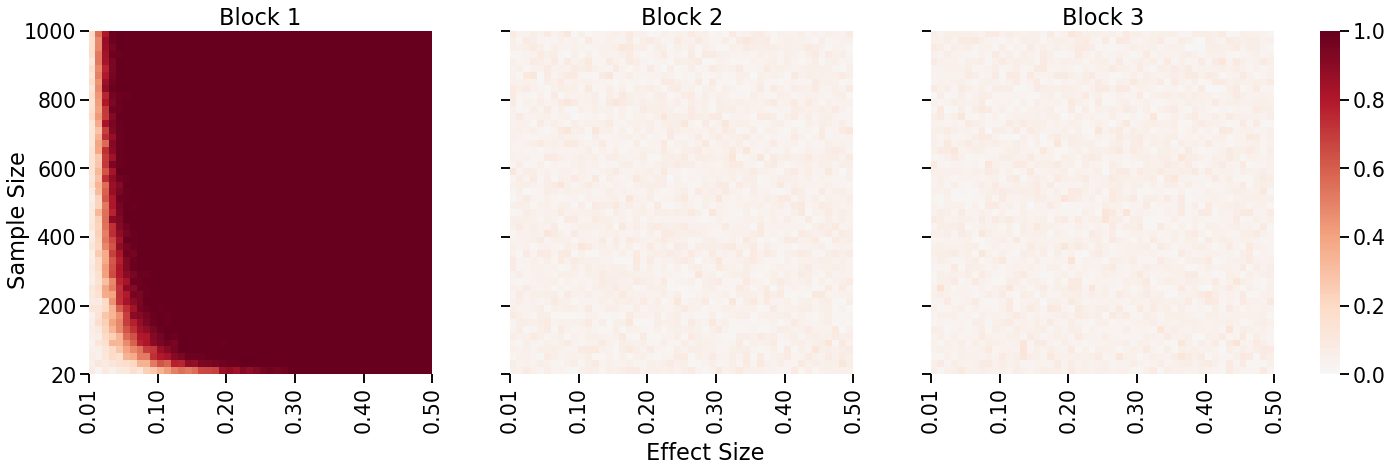

<IPython.core.display.Javascript object>

In [14]:
fmt = lambda x: "{:.2f}".format(x)

p = 0.5
spacing = 50
deltas = np.linspace(0, 1 - p, spacing + 1)[::10]
deltas[0] += 0.01
ms = np.linspace(0, 500, spacing + 1)[::10] * 2
ms[0] += 20

with sns.plotting_context("talk", font_scale=1.25):
    fig, ax = plt.subplots(
        1,
        4,
        gridspec_kw={"width_ratios": [1, 1, 1, 0.05]},
        figsize=(19, 6),
        constrained_layout=True,
    )

    for i in range(3):
        sns.heatmap(
            np.flipud(res_df[f"power_{i+1}"].values.reshape(spacing, -1)),
            ax=ax[i],
            square=True,
            center=0,
            cmap="RdBu_r",
            cbar_kws=dict(shrink=0.7),
            xticklabels=[fmt(d) for d in deltas],
            yticklabels=["{:.0f}".format(m) for m in ms],
            cbar_ax=ax[-1],
            vmin=0,
            vmax=1,
        )
        ax[i].set_xticks(np.arange(0, ax[0].get_xlim()[1] + 1, 10))
        ax[i].set_yticks(np.arange(0, ax[0].get_ylim()[0] + 1, 10)[::-1])
        if i != 0:
            ax[i].yaxis.set_major_formatter(plt.NullFormatter())
        ax[i].set_title(f"Block {i+1}")

    fig.text(-0.01, 0.5, "Sample Size", va="center", rotation="vertical")
    fig.text(0.5, -0.04, "Effect Size", va="center", ha="center")
    # fig.text(0.5, 1.05, "Omni", va="center", ha="center", fontsize=30)

    fig.savefig(
        "./figures/20200204_apriori_community_power.png", dpi=300, bbox_inches="tight"
    )
    fig.savefig("./figures/20200204_apriori_community_power.pdf", bbox_inches="tight")